# Topic Modeling

### Imports

In [1]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time

# Warnings
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore',category=DeprecationWarning)
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import imp
pd.options.mode.chained_assignment = 'raise' # [None, 'raise', 'warn']

# Gfx
from tqdm import tqdm, trange # https://www.geeksforgeeks.org/python-how-to-make-a-terminal-progress-bar-using-tqdm/
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas(desc='Processing...')

# NLP
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel, Nmf, LsiModel, LdaMulticore #https://thinkinfi.com/guide-to-build-best-lda-model-using-gensim-python/

from langdetect import detect
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import spacy

# NLP downloads
nlp = spacy.load('de_core_news_md')
stopwords = stopwords.words('german')

### First data exploration

>Based on the two datasets of "Tagesschau data" (as well as "Song Lyrics & more") we decide to do some Topic Modelling.  
We start out with loading a dataset and taking a first look at it and stay close to the example demo from the lecture.

In [2]:
df_tagesschau = pd.read_csv("tagesschau.csv")
df_tagesschau.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19492 entries, 0 to 19491
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   url          19492 non-null  object
 1   create_date  19492 non-null  object
 2   title        19492 non-null  object
 3   description  19492 non-null  object
 4   text         19433 non-null  object
 5   category     19492 non-null  object
 6   subcategory  19491 non-null  object
dtypes: object(7)
memory usage: 1.0+ MB


>Here we see already this dataset will need some work! Gathering a list of actions on what to do during cleaning.
>1. Comparing 'text' non-null count to RangeIndex, we see there are empty texts. These need removal.  
>2. Comparing 'subcategory' non-null count to RangeIndex, We see there is also one missing. Removal.  
>3. The dataset is large in size, with a shape of 19492 rows and 7 columns. So it may be best to slice some part off to not set my PC on fire.  
>
>I will attempt using a multicore lda model in order to reduce computational time.  
lda_multicore_model: https://thinkinfi.com/guide-to-build-best-lda-model-using-gensim-python/   

In [3]:
df_tagesschau[['title', 'description', 'text', 'category', 'subcategory']].head()

,title,description,text,category,subcategory
0,Winter in Afghanistan: Hunderttausende Kinder ...,Hunderttausende Kinder leiden in afghanischen ...,Der kalte Winter in Afghanistan trifft vor all...,ausland,winter-afghanistan-101.html
1,Silvester in Deutschland: Ruhiger Start ins ne...,Aufgrund der Einschränkungen durch die Corona-...,Die größte Silvesterparty Deutschlands am Bran...,inland,silvester-deutschland-107.html
2,Notfallzulassung erteilt: WHO lässt Impfstoff ...,Nach mehreren Ländern hat auch die Weltgesundh...,Die Weltgesundheitsorganisation WHO hat den Im...,wirtschaft,who-notfallzulassung-biontech-101.html
3,Briten ohne Erasmus: Keine Gelder für Studiere...,Zum Handelsabkommen mit der EU gehört auch Gro...,Auslandserfahrung macht sich in jedem Lebensla...,ausland,grossbritannien-erasmus-ausstieg-101.html
4,Wechselkurse 2021: Wie geht es mit dem Euro we...,Der Euro ist so teuer wie seit April 2018 nich...,Der Euro hat in diesem Jahr ein unerwartetes C...,wirtschaft,finanzen


In [4]:
# Be careful with calling style on large dataframes, it will attempt to show all of them!
df_tagesschau[['title', 'text']].head(1).style 

,title,text
0,Winter in Afghanistan: Hunderttausende Kinder von Kälte bedroht,"Der kalte Winter in Afghanistan trifft vor allem die Ärmsten der Armen und die Jüngsten. Die Kinder in den Flüchtlingslagern am Stadtrand von Kabul und anderswo in Afghanistan, sind den eisigen Temperaturen weitgehend schutzlos ausgeliefert, wie auf Filmmaterial der Nachrichtenagentur AP zu sehen war.Vor allem nachts sei es bitter kalt, klagt Mohammad Dad, der mit seinen Eltern und Geschwistern in einem Lager für ""internally displaced persons"" lebt, Flüchtlinge im eigenen Land. Es gebe kein Holz und keine Kohle zum Heizen oder Kochen, so der zehnjährige Junge. Und sowieso hätten sie weder Reis noch Mehl, um etwas zu essen zuzubereiten. Auch Decken gebe es keine.In dem Flüchtlingscamp am nördlichen Stadtrand von Kabul leben mehr als 700 Familien, die vor den Kämpfen geflohen sind. Sie verbrennen Müll, den sie auf den Straßen einsammeln, um mit einem Feuer am Abend wenigstens ein bisschen Wärme zu erzeugen. Die Kinder seien alle krank, klagt Großmutter Raihan. ""Sie husten die ganze Nacht. Wir haben kein Geld, um Medizin zu kaufen oder mit ihnen zum Art zu gehen. Unser Leben ist wirklich sehr schwer.""Allein im abgelaufenen Jahr sind nach UN-Angaben Hunderttausende Menschen infolge der Kämpfe zu Flüchtlingen im eigenen Land geworden. Ohne angemessene Winterkleidung und Heizung seien mehr als 300.000 Kinder von Krankheit oder sogar Tod bedroht, so die Hilfsorganisation Save the Children. Der frühe Schneefall im Norden Afghanistans habe die Menschen hart getroffen, teilte das UN-Welternährungsprogramm WFP bereits vor einigen Wochen mit. Der anhaltende Konflikt und die Corona-Pandemie mache die Lage noch schlimmer, so WFP-Sprecherin Frances Kennedy.""Wir beobachten eine Zunahme von Kampfhandlungen im ganzen Land und das zwingt viele Menschen aus ihren Siedlungsgebieten zu fliehen"", sagt Kennedy. Der frühe Schneefall in diesem Jahr habe das Leben noch schwieriger gemacht, vor allem in den abgelegenen Regionen.Besonders schlimm ist es nach Einschätzung der Hilfsorganisation Save the Children in der nördlichen Provinz Balkh, wo auch die Bundeswehr ihren Standort hat. Dort lägen die Temperaturen jetzt bei -10 Grad Celsius. Doch in den kältesten Regionen Afghanistans können die Temperaturen im Winter auf unter -20 Grad sinken.Winter-Hilfspakete für mehr als 100.000 Familien sollen die größte Not lindern helfen. Dazu gehörten ein Heizgerät und Brennstoff, Decken und Winterkleidung für Kinder."


In [5]:
print(f"The average length of texts in this dataset is {df_tagesschau.text.str.len().median()} characters.")

The average length of texts in this dataset is 3198.0 characters.


>We will use 3198 characters for point 3 on our cleansing list to slice the top half off to avoid setting the PC on fire.

In [6]:
df_tagesschau.describe()

,url,create_date,title,description,text,category,subcategory
count,19492,19492,19492,19492,19433,19492,19491
unique,19491,18453,19478,19053,19426,18,6478
top,https://www.tagesschau.de/wirtschaft/verbrauch...,2021-11-24 14:11:57,Regeln zur Einreise: Was Urlauber beachten müssen,,"Das Gespräch führte Eckart Aretz, tagesschau.de",ausland,europa
freq,2,4,2,240,4,7431,2736


>4. Looking at 'url', comparing 'count' to 'unique', we see there is another duplicate. Removal. 
>5. Looking at column 'text', comparing 'count' to 'unique', we see there are some texts twice. Removal.

### Clean

>We walk through the list we have set up before, following cleaning operations 1 to 5.  
>For the 6th point we also make sure that we just analyze the German texts.

In [7]:
################################
# Follow list from exploration #
################################

# 0. To avoid accidently slicing top half more than once:
df_tagesschau = pd.read_csv("tagesschau.csv")

print(f"Number of rows before cleaning: {df_tagesschau.shape[0]}")

# 1. Removal of empty 'text':
df_tagesschau['text'].replace('', np.nan, inplace=True)
df_tagesschau.dropna(subset=['text'], inplace=True)

# 2. Removal of empty 'subcategory':
df_tagesschau['subcategory'].replace('', np.nan, inplace=True)
df_tagesschau.dropna(subset=['subcategory'], inplace=True)

# 3. Slice off top half of the dataset to avoid fires:
df_tagesschau = df_tagesschau[df_tagesschau.text.str.len() <= df_tagesschau.text.str.len().median()]
#df_tagesschau = df_tagesschau[df_tagesschau.text.str.len() <= 1000] # for testing purposes

# 4. Removal of redundant 'url':
df_tagesschau.drop_duplicates('url', inplace=True)

# 5. Removal of redundant 'text':
df_tagesschau.drop_duplicates('text', inplace=True)

# 6. Select to get German text through langdetect:
df_tagesschau = df_tagesschau[df_tagesschau['text'].apply(detect)=='de']

print(f"Number of rows after cleaning: {df_tagesschau.shape[0]}")

Number of rows before cleaning: 19492
Number of rows after cleaning: 9709


### Normalize

In [8]:
def normalize_document(doc, stopwords):
    '''
    This functions handles normalization. It was inspired from the lecture but has been expanded.
    Its actions are:
    1. Reduce text to words and spaces
    2. Set everything to lower cases
    3. Reduce two spaces to one
    4. Remove numbers
    5. Lemmatize and remove stopwords
    Returns object 'lemmas'
    '''
    # 1. Reduce text to words and spaces
    doc = re.sub(r'[^\w\s]', '', doc)
    
    # 2. Set everything to lower cases
    doc = doc.lower()

    # 3. Reduce two spaces to one
    doc = re.sub(r"\s+", " ", doc)
    
    # 4. Remove digits
    doc = re.sub(r"\d", "", doc)

    # 5. Lemmatize and remove stopwords
    nlpdoc = nlp(doc)
    lemmas = [word.lemma_ for word in nlpdoc if word.lemma_ not in stopwords]
    return lemmas


print(normalize_document.__doc__)


    This functions handles normalization. It was inspired from the lecture but has been expanded.
    Its actions are:
    1. Reduce text to words and spaces
    2. Set everything to lower cases
    3. Reduce two spaces to one
    4. Remove numbers
    5. Lemmatize and remove stopwords
    Returns object 'lemmas'
    


In [9]:
df_tagesschau["normalized"] = df_tagesschau.text.progress_apply(
    lambda x: normalize_document(x, stopwords))

Processing...:   0%|          | 0/9709 [00:00<?, ?it/s]

In [10]:
df_tagesschau.head(3)

,url,create_date,title,description,text,category,subcategory,normalized
0,https://www.tagesschau.de/ausland/winter-afgha...,2021-01-01 08:16:19,Winter in Afghanistan: Hunderttausende Kinder ...,Hunderttausende Kinder leiden in afghanischen ...,Der kalte Winter in Afghanistan trifft vor all...,ausland,winter-afghanistan-101.html,"[kalt, Winter, Afghanistan, treffen, arm, arme..."
1,https://www.tagesschau.de/inland/silvester-deu...,2021-01-01 09:35:44,Silvester in Deutschland: Ruhiger Start ins ne...,Aufgrund der Einschränkungen durch die Corona-...,Die größte Silvesterparty Deutschlands am Bran...,inland,silvester-deutschland-107.html,"[groß, Silvesterparty, Deutschland, Brandenbur..."
2,https://www.tagesschau.de/wirtschaft/who-notfa...,2021-01-01 09:50:01,Notfallzulassung erteilt: WHO lässt Impfstoff ...,Nach mehreren Ländern hat auch die Weltgesundh...,Die Weltgesundheitsorganisation WHO hat den Im...,wirtschaft,who-notfallzulassung-biontech-101.html,"[Weltgesundheitsorganisation, who, Impfstoff, ..."


### Create Bag of Words

LDA can only understand numeric values, so we must convert all of the cleaned text into numbers.

In [11]:
# Create dictionary
dictionary = Dictionary(df_tagesschau.normalized)
# Take a look at the dictionary
dictionary.token2id

{' ': 0,
 '--': 1,
 'Abend': 2,
 'Afghanistan': 3,
 'Art': 4,
 'Balkh': 5,
 'Brennstoff': 6,
 'Bundeswehr': 7,
 'Celsius': 8,
 'Coronapandemie': 9,
 'Dad': 10,
 'Einschätzung': 11,
 'Eltern': 12,
 'Familie': 13,
 'Feuer': 14,
 'Filmmaterial': 15,
 'Flüchtling': 16,
 'Flüchtlingscamp': 17,
 'Flüchtlingslager': 18,
 'France': 19,
 'Geld': 20,
 'Geschwister': 21,
 'Grad': 22,
 'Großmutter': 23,
 'Heizgerät': 24,
 'Heizung': 25,
 'Hilfsorganisation': 26,
 'Holz': 27,
 'Jahr': 28,
 'Kabul': 29,
 'Kampfhandlung': 30,
 'Kennedy': 31,
 'Kennedywir': 32,
 'Kind': 33,
 'Kohle': 34,
 'Konflikt': 35,
 'Krankheit': 36,
 'Lage': 37,
 'Lager': 38,
 'Land': 39,
 'Leben': 40,
 'Medizin': 41,
 'Mehl': 42,
 'Mensch': 43,
 'Mohammad': 44,
 'Müll': 45,
 'Nachrichtenagentur': 46,
 'Nacht': 47,
 'Norden': 48,
 'Not': 49,
 'Persons': 50,
 'Provinz': 51,
 'Raihan': 52,
 'Region': 53,
 'Regionenbesonder': 54,
 'Reis': 55,
 'Schneefall': 56,
 'Schwerallein': 57,
 'Siedlungsgebiet': 58,
 'Stadtrand': 59,
 'Stando

In [12]:
# Check out the 10 most common before filtering
dictionary.most_common(10)

[(' ', 51244),
 ('sagen', 12597),
 ('Jahr', 11104),
 ('sollen', 9865),
 ('mehr', 9040),
 ('Prozent', 7827),
 ('geben', 7717),
 ('Mensch', 7384),
 ('Land', 6523),
 ('neu', 5908)]

In [13]:
print(f"Length before filtering:{len(dictionary)}")
dictionary.filter_extremes(no_below=2, no_above=0.5)
print(f"Length after filtering:{len(dictionary)}")

Length before filtering:147513
Length after filtering:54370


In [14]:
# Check out the 10 most common after filtering
dictionary.most_common(10)

[('Prozent', 7827),
 ('Mensch', 7384),
 ('Land', 6523),
 ('neu', 5908),
 ('Deutschland', 5294),
 ('gehen', 5171),
 ('seit', 5123),
 ('kommen', 5104),
 ('groß', 4850),
 ('müssen', 4477)]

In [15]:
# Create term document frequency (corpus)
corpus = [dictionary.doc2bow(text) for text in df_tagesschau.normalized]

>Testrun of https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=stopwords,             # remove stop words
                             #lowercase=True,                  # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}'   # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )



### LDA Models

>We start experimenting a bit with the LDA model and the number of topics. For this, a simple approach of manually changing hyperparameters to begin with sufficed. Later we can build a little function to compare the different parameters and search for what is better, which also allows us to integrade tqdm_notebook again. The est. runtime of the following two small models is between 20 to 30 seconds on a non-boosting (underclocked) AMD Ryzen 5900X.  
>
>This here shows that it can sometimes make sense to start working with it to get a general idea of how the models behave. I use the multicore variant of LDA, as it works considerably quicker than a single core pipeline. However, it does not allow for autotuning of alpha. So let's take a quick look ahead and compare two models and how they respond to alpha being assymetric vs symmetric.
>
>**Our goal is to first look at the Perplexity Score, CV Coherence Score and U_Mass Coherence score, elaborate on them and evaluate the results.**  
>
> Afterwards we can proceed to finding the right number of topics and other hyperparameters.  
>  

In [34]:
# https://radimrehurek.com/gensim/models/ldamodel.html #

start_time = time.time()
#########################
# Multicore LDA Model 1 #
#########################
NUM_TOPICS = 8
lda_multicore_1 = LdaMulticore(corpus=corpus,
                                    num_topics = NUM_TOPICS,
                                    id2word=dictionary,
                                    random_state=42,
                                    alpha='asymmetric', # this model is asymmetric
                                    passes=6)

# Saving trained model
lda_multicore_1.save('Multicore_LDA_Model_1')

# Loading trained model
lda_multicore_1 = gensim.models.ldamodel.LdaModel.load('Multicore_LDA_Model_1')

## Print time taken to train the model
print("It took %s seconds to train the model." % (time.time() - start_time))

It took 28.65756607055664 seconds to train the model.


In [35]:
start_time = time.time()

#########################
# Multicore LDA Model 2 #
#########################

NUM_TOPICS = 8
lda_multicore_2 = LdaMulticore(corpus=corpus,
                                    num_topics = NUM_TOPICS,
                                    id2word=dictionary,
                                    random_state=42,
                                    alpha='symmetric',
                                    passes=6)

# Saving trained model
lda_multicore_2.save('Multicore_LDA_Model_2')

# Loading trained model
lda_multicore_2 = gensim.models.ldamodel.LdaModel.load('Multicore_LDA_Model_2')

## Print time taken to train the model
print("It took %s seconds to train the model." % (time.time() - start_time))

It took 28.365281581878662 seconds to train the model.


In [36]:
# Perplexity Score of Model 1 #
print('Perplexity Score of Model 1: ', lda_multicore_1.log_perplexity(corpus))

# CV Coherence Score of Model 1 #
cv_coherence = gensim.models.CoherenceModel(model=lda_multicore_1, texts=df_tagesschau.normalized, dictionary=dictionary, coherence='c_v')
cv_coherence_lda = cv_coherence.get_coherence()
print('CV Coherence Score of Model 1: ', cv_coherence_lda)

# U_Mass Coherence Score of Model 1 #
u_mass_coherence = gensim.models.CoherenceModel(model=lda_multicore_1, texts=df_tagesschau.normalized, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence.get_coherence()
print("U_Mass Coherence Score of Model 1: ", u_mass_coherence_lda)

Perplexity Score of Model 1:  -8.814092907500397
CV Coherence Score of Model 1:  0.31618844073405156
U_Mass Coherence Score of Model 1:  -1.3148546759562607


In [37]:
# Perplexity Score of Model 2 #
print("Perplexity Score of Model 2: ", lda_multicore_2.log_perplexity(corpus))

# CV Coherence Score of Model 2 #
cv_coherence = gensim.models.CoherenceModel(model=lda_multicore_2, texts=df_tagesschau.normalized, dictionary=dictionary, coherence='c_v')
cv_coherence_lda = cv_coherence.get_coherence()
print("CV Coherence Score of Model 2: ", cv_coherence_lda)

# U_Mass Coherence Score of Model 2 #
u_mass_coherence = gensim.models.CoherenceModel(model=lda_multicore_2, texts=df_tagesschau.normalized, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence.get_coherence()
print("U_Mass Coherence Score of Model 2: ", u_mass_coherence_lda)


Perplexity Score of Model 2:  -8.814835472610387
CV Coherence Score of Model 2:  0.30729418202862596
U_Mass Coherence Score of Model 2:  -1.297284944960931


>The question remains if there is a statistical measure which helps us find the optimal hyperparameters to begin with? To some degree:  
>  
>**Perplexity Score** is a measurement of how well a probability model predicts a sample. The smaller this number is, the better. Model 1 is smaller than Model 2, so it performed better.  
>**CV Coherence** is often used but rarely recommended. This has a reason: The author advised against it *for randomly generated word sets*. For all else it should be fine. The higher it is the better the result. Here Model 1 beats Model 2.  
>**U_Mass Coherence Score** calculates how often two words appear together in a corpus. The lower the negative is, the better the coherence score is. It confirms that Model 1 performed better.  
>
>We should not make the mistake to select alpha based on this however. LDA is multivariate and alpha may pull for better or worse when changing number of topics.
>
>Author on CV Coherence for randomly generated word sets:  
 https://github.com/dice-group/Palmetto/issues/13#issuecomment-371553052

In [22]:
# Some browsing through the better result to understand the dataset.

i = 0
df_tagesschau.text[i]  # Document
lda_multicore_1.get_document_topics(corpus[i]) # Topic Distribution of Document
lda_multicore_1.show_topic(0) # Word Distribution for most relevant topic

[('Prozent', 0.005905604),
 ('Land', 0.0048882277),
 ('Unternehmen', 0.0042385673),
 ('neu', 0.0042023975),
 ('Million', 0.0037970291),
 ('gehen', 0.0036946975),
 ('seit', 0.0035494012),
 ('groß', 0.0032665632),
 ('bereits', 0.0032410515),
 ('erster', 0.0031935794)]

In [23]:
# Add important topic to dataframe (this has not been optimized yet, top_topic and top_topic_p will be replaced in the end, no worries yet) :-)
topics = lda_multicore_1.get_document_topics(corpus)
df_tagesschau['top_topic'] = [sorted(topics[i], key=lambda x: x[1], reverse=True)[
    0][0] for i, text in enumerate(df_tagesschau.text)]
df_tagesschau['top_topic_p'] = [sorted(lda_multicore_1[corpus][i], key=lambda x: x[1], reverse=True)[
    0][1] for i, text in enumerate(df_tagesschau.text)]

In [24]:
df_tagesschau.head(2)

,url,create_date,title,description,text,category,subcategory,normalized,top_topic,top_topic_p
0,https://www.tagesschau.de/ausland/winter-afgha...,2021-01-01 08:16:19,Winter in Afghanistan: Hunderttausende Kinder ...,Hunderttausende Kinder leiden in afghanischen ...,Der kalte Winter in Afghanistan trifft vor all...,ausland,winter-afghanistan-101.html,"[kalt, Winter, Afghanistan, treffen, arm, arme...",4,0.843962
1,https://www.tagesschau.de/inland/silvester-deu...,2021-01-01 09:35:44,Silvester in Deutschland: Ruhiger Start ins ne...,Aufgrund der Einschränkungen durch die Corona-...,Die größte Silvesterparty Deutschlands am Bran...,inland,silvester-deutschland-107.html,"[groß, Silvesterparty, Deutschland, Brandenbur...",2,0.383199


### Finding the right number of topics
>In order to maximize topic coherence, we build a small function. Its groundwork stems from the lecture's demo but it was walked through, understood, expanded and modified.    
>
>We concentrate on the U_Mass Coherence Score and leave the CV Coherence Score aside, as only one is needed, and as discussed earlier the author recommends it!  
>
>Whether alpha to symmetric or assymetric is better questionable, so let's wrap a simple loop around it and let the scores decide. In our Model 2 earlier I ran with the same number of topics and symmetric performed better. Now to find out for sure:

Running asymmetric vs symmetric:   0%|          | 0/2 [00:00<?, ?it/s]

Testing number of topics:   0%|          | 0/14 [00:00<?, ?it/s]

Testing number of topics:   0%|          | 0/14 [00:00<?, ?it/s]

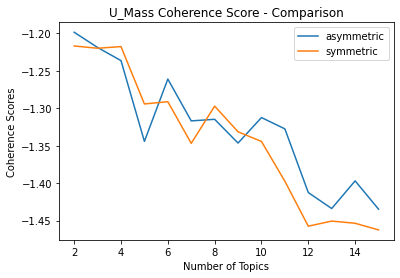

In [30]:
# The framework is partly from the lecture, but modified and adapted. I concentrate on u_mass score as it is supposedly more robust.
# alpha would on 'auto': It learns an asymmetric prior from the corpus (not available if distributed==True) according to the documentation:
# https://radimrehurek.com/gensim/models/ldamodel.html
# However, I am using the Multicore variant of the LDA Model, in which autotuning of alpha is NOT integrated.
# This is why I am forced to loop around once more, but it is only two options so it is not that bad.
list_alpha = ['asymmetric', 'symmetric']


###############
# Fruit loops #
###############

# We first let it run through the ranges of numbers of topics, then through each type of alpha and plot it.
fig, ax = plt.subplots()

for alpha in tqdm_notebook(list_alpha, "Running asymmetric vs symmetric"):
    # Store results #
    num_topics = []
    u_mass_coherence = []

    for i in tqdm_notebook(range(2, 16, 1), "Testing number of topics: "):
        # LDA
        multicore_lda_model = LdaMulticore(corpus=corpus, num_topics=i, id2word=dictionary,
                        iterations=50, alpha=alpha, random_state=42, passes=6) # random_state is the answer to life, the universe, and everything.
        # U Mass Coherence
        um_model = CoherenceModel(model=multicore_lda_model, corpus=corpus,
                            dictionary=dictionary, coherence='u_mass', texts=df_tagesschau.normalized)   # 'c_v' can get used but is questionable with random sets of words. Only one is needed.
        num_topics.append(i)
        u_mass_coherence.append(um_model.get_coherence()) # taking the u_mass coherence

    ax.plot(num_topics, u_mass_coherence, label=alpha)    


ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence Scores")
plt.title("U_Mass Coherence Score - Comparison")
plt.legend()
plt.show()

### Evaluation

>The optimal LDA Model is thus found at the bottom of the symmetric alpha at number of topics = 12.

In [33]:
start_time = time.time()

#####################
# Optimal LDA Model #
#####################

#NUM_TOPICS = 12
optimal_model = LdaMulticore(corpus=corpus,
                                    num_topics = 12,
                                    id2word=dictionary,
                                    random_state=42,
                                    iterations=50,
                                    alpha='symmetric',
                                    passes=6)

# Saving trained model
optimal_model.save('Multicore_Optimal_Model')

# Loading trained model
optimal_model = gensim.models.ldamodel.LdaModel.load('Multicore_Optimal_Model')

## Print time taken to train the model
print("It took %s seconds to train the model with optimized parameters." % (time.time() - start_time))


It took 28.804123401641846 seconds to train the model with optimized parameters.


In [32]:
# Perplexity Score of optimal_model #
print('Perplexity Score of optimal_model: ', optimal_model.log_perplexity(corpus))

# CV Coherence Score of optimal_model #
cv_coherence = gensim.models.CoherenceModel(model=optimal_model, texts=df_tagesschau.normalized, dictionary=dictionary, coherence='c_v')
cv_coherence_lda = cv_coherence.get_coherence()
print('CV Coherence Score of optimal_model: ', cv_coherence_lda)

# U_Mass Coherence Score of optimal_model #
u_mass_coherence = gensim.models.CoherenceModel(model=optimal_model, texts=df_tagesschau.normalized, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence.get_coherence()
print("U_Mass Coherence Score of optimal_model: ", u_mass_coherence_lda)

Perplexity Score of optimal_model:  -8.847503871526008
CV Coherence Score of optimal_model:  0.32757760102151046
U_Mass Coherence Score of optimal_model:  -1.4574095007652523


>The model reaches better scores than our previous manual runs. So our optimization can be described as a success. But there is more air above. We could also run with more hyperparameters - for example the amount of passes!  
>
> I have read that for large corpii it may be possible to train the model with 1 pass. For fun, let's repeat it with a single pass and see how the scores develop!  
>Mentioned by Radim Rehurek, author of gensim: https://groups.google.com/g/gensim/c/OF7XL1lm8mY

Running asymmetric vs symmetric:   0%|          | 0/2 [00:00<?, ?it/s]

Testing number of topics:   0%|          | 0/14 [00:00<?, ?it/s]

Testing number of topics:   0%|          | 0/14 [00:00<?, ?it/s]

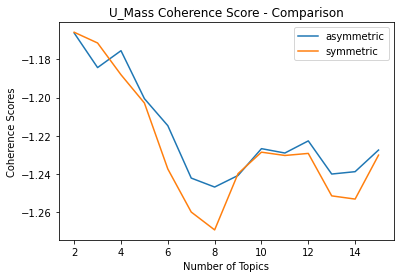

In [38]:
# The framework is partly from the lecture, but modified and adapted. I concentrate on u_mass score as it is supposedly more robust.
# alpha would on 'auto': It learns an asymmetric prior from the corpus (not available if distributed==True) according to the documentation:
# https://radimrehurek.com/gensim/models/ldamodel.html
# However, I am using the Multicore variant of the LDA Model, in which autotuning of alpha is NOT integrated.
# This is why I am forced to loop around once more, but it is only two options so it is not that bad.
list_alpha = ['asymmetric', 'symmetric']


###############
# Fruit loops #
###############

# We first let it run through the ranges of numbers of topics, then through each type of alpha and plot it.
fig, ax = plt.subplots()

for alpha in tqdm_notebook(list_alpha, "Running asymmetric vs symmetric"):
    # Store results #
    num_topics = []
    u_mass_coherence = []

    for i in tqdm_notebook(range(2, 16, 1), "Testing number of topics: "):
        # LDA
        multicore_lda_model = LdaMulticore(corpus=corpus, num_topics=i, id2word=dictionary,
                        iterations=50, alpha=alpha, random_state=42, passes=1) # random_state is the answer to life, the universe, and everything.
        # U Mass Coherence
        um_model = CoherenceModel(model=multicore_lda_model, corpus=corpus,
                            dictionary=dictionary, coherence='u_mass', texts=df_tagesschau.normalized)   # 'c_v' can get used but is questionable with random sets of words. Only one is needed.
        num_topics.append(i)
        u_mass_coherence.append(um_model.get_coherence()) # taking the u_mass coherence

    ax.plot(num_topics, u_mass_coherence, label=alpha)    


ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence Scores")
plt.title("U_Mass Coherence Score - Comparison")
plt.legend()
plt.show()

>Let's take the suggest params from the single-pass model:

In [39]:
start_time = time.time()

#########################
# Single-Pass LDA Model #
#########################

sp_model = LdaMulticore(corpus=corpus,
                                    num_topics = 8,
                                    id2word=dictionary,
                                    random_state=42,
                                    iterations=50,
                                    alpha='symmetric',
                                    passes=1)

# Saving trained model
sp_model.save('SP_Model')

# Loading trained model
sp_model = gensim.models.ldamodel.LdaModel.load('SP_Model')

## Print time taken to train the model
print("It took %s seconds to train the model with optimized parameters." % (time.time() - start_time))

It took 16.727201461791992 seconds to train the model with optimized parameters.


In [45]:
# Perplexity Score of optimal_model #
print('Perplexity Score of sp_model: ', sp_model.log_perplexity(corpus))

# CV Coherence Score of optimal_model #
cv_coherence = gensim.models.CoherenceModel(model=sp_model, texts=df_tagesschau.normalized, dictionary=dictionary, coherence='c_v')
cv_coherence_lda = cv_coherence.get_coherence()
print('CV Coherence Score of sp_model: ', cv_coherence_lda)

# U_Mass Coherence Score of optimal_model #
u_mass_coherence = gensim.models.CoherenceModel(model=sp_model, texts=df_tagesschau.normalized, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence.get_coherence()
print("U_Mass Coherence Score of sp_model: ", u_mass_coherence_lda)

Perplexity Score of sp_model:  -9.170433582400737
CV Coherence Score of sp_model:  0.26698668044173357
U_Mass Coherence Score of sp_model:  -1.2692457168155595


>It seems that our 'optimal_model' with 6 passes did much better than the single pass model 'sp_model'. The perplexity score is not as low as with the optimal model, the CV coherence below the 30s, and U_mass indicates a worse (higher) score as well.  
>  
>**Hence we stick to the optimal model found earlier!**

### Visualization

>Visualizing the intertopic distance map with gensim's inbuilt function for the optimal model:

In [42]:
######################
# Visualizing topics #
######################
lda_viz = gensimvis.prepare(optimal_model, corpus, dictionary)
pyLDAvis.display(lda_viz)

c:\Users\janni\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [43]:
# Add important topic to dataframe (this time with the optimized model) :-)
topics = optimal_model.get_document_topics(corpus)
df_tagesschau['top_topic'] = [sorted(topics[i], key=lambda x: x[1], reverse=True)[
    0][0] for i, text in enumerate(df_tagesschau.text)]
df_tagesschau['top_topic_p'] = [sorted(optimal_model[corpus][i], key=lambda x: x[1], reverse=True)[
    0][1] for i, text in enumerate(df_tagesschau.text)]

In [44]:
df_tagesschau[['title', 'description', 'text', 'category', 'subcategory','top_topic','top_topic_p']].head(3)

,title,description,text,category,subcategory,top_topic,top_topic_p
0,Winter in Afghanistan: Hunderttausende Kinder ...,Hunderttausende Kinder leiden in afghanischen ...,Der kalte Winter in Afghanistan trifft vor all...,ausland,winter-afghanistan-101.html,4,0.904058
1,Silvester in Deutschland: Ruhiger Start ins ne...,Aufgrund der Einschränkungen durch die Corona-...,Die größte Silvesterparty Deutschlands am Bran...,inland,silvester-deutschland-107.html,11,0.462178
2,Notfallzulassung erteilt: WHO lässt Impfstoff ...,Nach mehreren Ländern hat auch die Weltgesundh...,Die Weltgesundheitsorganisation WHO hat den Im...,wirtschaft,who-notfallzulassung-biontech-101.html,1,0.805394


> Let us add some more descriptive, expressive descriptions to the top topics. We read them from the visualization's estimated term frequency within the selected topic and simply call them 'topic', as that's what all of this is about.

In [46]:
df_backup = df_tagesschau

In [51]:
descriptive_topics = {"0": "Prozente und Menschen", "1": "Wirtschaft - der Euro und die Inflation", "2": "Land und Menschen", "3": "Der Überfall auf die Ukraine", "4": "Afghanistan heute",
"5": "Corona Zahlen dieser Woche", "6": "China im Wandel", "7": "Was macht die Ampelkoalition heute", "8": "Impfungen in Deutschland", "9": "Israel im Fokus",
"10": "Sport","11": "Die USA, Polizeigewalt und Trump","12": "Unternehmen in Deutschland"}


In [52]:
df_tagesschau['topic'] = df_tagesschau.top_topic.apply(lambda x: descriptive_topics[str(x)])

In [53]:
df_tagesschau

,url,create_date,title,description,text,category,subcategory,normalized,top_topic,top_topic_p,topic
0,https://www.tagesschau.de/ausland/winter-afgha...,2021-01-01 08:16:19,Winter in Afghanistan: Hunderttausende Kinder ...,Hunderttausende Kinder leiden in afghanischen ...,Der kalte Winter in Afghanistan trifft vor all...,ausland,winter-afghanistan-101.html,"[kalt, Winter, Afghanistan, treffen, arm, arme...",4,0.904058,Afghanistan heute
1,https://www.tagesschau.de/inland/silvester-deu...,2021-01-01 09:35:44,Silvester in Deutschland: Ruhiger Start ins ne...,Aufgrund der Einschränkungen durch die Corona-...,Die größte Silvesterparty Deutschlands am Bran...,inland,silvester-deutschland-107.html,"[groß, Silvesterparty, Deutschland, Brandenbur...",11,0.462178,"Die USA, Polizeigewalt und Trump"
2,https://www.tagesschau.de/wirtschaft/who-notfa...,2021-01-01 09:50:01,Notfallzulassung erteilt: WHO lässt Impfstoff ...,Nach mehreren Ländern hat auch die Weltgesundh...,Die Weltgesundheitsorganisation WHO hat den Im...,wirtschaft,who-notfallzulassung-biontech-101.html,"[Weltgesundheitsorganisation, who, Impfstoff, ...",1,0.805394,Wirtschaft - der Euro und die Inflation
6,https://www.tagesschau.de/ausland/neujahrsmess...,2021-01-01 17:45:46,"Neujahrsmesse im Vatikan: ""Gutes Jahr, wenn wi...",Zum Jahresbeginn hat Papst Franziskus die Mens...,Die katholische Kirche hat das neue Jahr mit e...,ausland,neujahrsmesse-vatikan-101.html,"[katholisch, Kirche, neu, Jahr, festmesse, Vat...",4,0.367499,Afghanistan heute
7,https://www.tagesschau.de/ausland/neujahrssege...,2021-01-01 18:05:38,Papst Franziskus: Neujahrssegen trotz Ischias-...,Die Gerüchte über eine Erkrankung des Papstes ...,Für viele Gläubige war auch dies eine wichtige...,ausland,neujahrssegen-vatikan-101.html,"[vieler, gläubige, wichtig, Neujahrsbotschaft,...",6,0.979380,China im Wandel
...,...,...,...,...,...,...,...,...,...,...,...
19476,https://www.tagesschau.de/wirtschaft/weltwirts...,2022-04-14 17:49:09,Bis zum Sommer: Russland schränkt Getreideexpo...,Russland hat die Getreidexporte in vier ehemal...,Russland hat Beschränkungen für den Export von...,wirtschaft,weltwirtschaft,"[Russland, Beschränkung, Export, Getreide, vie...",5,0.836415,Corona Zahlen dieser Woche
19482,https://www.tagesschau.de/ausland/afrika/afrik...,2022-04-14 17:49:12,"Steigende Preise in Ostafrika: ""Das Leben ist ...",In Kenia stammt ein großer Teil des importiert...,Früh am Morgen in einem Armenviertel in Kenias...,ausland,afrika,"[früh, morgen, Armenviertel, Kenias, Hauptstad...",7,0.426541,Was macht die Ampelkoalition heute
19483,https://www.tagesschau.de/wirtschaft/weltwirts...,2022-04-14 17:49:13,Folgen des Ukraine-Kriegs: Ostafrika fehlt der...,Russland und die Ukraine sind für Länder wie K...,Am Rande einer der Armensiedlungen in Kenias H...,wirtschaft,weltwirtschaft,"[Rand, Armensiedlung, Kenias, Hauptstadt, Nair...",5,0.551584,Corona Zahlen dieser Woche
19486,https://www.tagesschau.de/wirtschaft/verbrauch...,2022-04-14 17:49:14,Bundesverband des Lebensmittelhandels: Deutsch...,Mit Beginn des Ukraine-Krieges haben die Deuts...,Trotz Meldungen über Engpässe bei einzelnen Na...,wirtschaft,verbraucher,"[trotz, Meldung, engpässe, einzeln, Nahrungsmi...",8,0.992981,Impfungen in Deutschland


In [56]:
descriptive_topics

{'0': 'Prozente und Menschen',
 '1': 'Wirtschaft - der Euro und die Inflation',
 '2': 'Land und Menschen',
 '3': 'Der Überfall auf die Ukraine',
 '4': 'Afghanistan heute',
 '5': 'Corona Zahlen dieser Woche',
 '6': 'China im Wandel',
 '7': 'Was macht die Ampelkoalition heute',
 '8': 'Impfungen in Deutschland',
 '9': 'Israel im Fokus',
 '10': 'Sport',
 '11': 'Die USA, Polizeigewalt und Trump',
 '12': 'Unternehmen in Deutschland'}

>Now the reader can search for a topic from this list and read articles about it in our Tagesschau Collection!